# Investigate a Dataset
## Titanic Survival Exploration: What factors make a passenger more likely to survive?
### Load Dataset

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# Load the dataset
in_file = 'titanic_data.csv'
full_data = pd.read_csv(in_file)

# Print the first data entries
display(full_data.head())
outcomes = full_data['Survived']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


These are the features in the Titanic data:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin**: Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Note: I used these descriptions and some code from the MLND Titantic project.

In [20]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Missing Values

**Age**, **Embarked**, and **Cabin** contain missing values. Since only 22% of the **Cabin** values are filled, I will not use **Cabin** in my predictions. I will fill in the missing **Age** values with the mean of **Age** across **Sex** and **Pclass**. For **Embarked**, I will use the most frequent **Embarked** value, as there are only two missing values.

In [21]:
missing_age = full_data[full_data['Age'].isnull()]
mean_age = full_data.groupby(['Sex','Pclass'])['Age'].mean()

def fix_age(passenger):
    if pd.isnull(passenger['Age']):
        return mean_age[passenger['Sex'],passenger['Pclass']]
    else:
        return passenger['Age']
full_data['Age'] = full_data.apply(fix_age, axis=1)    

In [22]:
full_data[full_data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [23]:
full_data[(full_data['Ticket']=='113572') | (full_data['Cabin']=='B28')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [24]:
full_data.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [25]:
full_data['Embarked'].fillna('S',inplace=True)

### Visualize Dataset and Make Predictions

I will define a derived feature **person**, which is Child if a passenger is less than 10 years of age, and is otherwise equal to the Sex of the passenger.

In [26]:
def type_person(gender, age):
    if age < 10:
        return 'Child'
    elif gender=='female':
        return 'Woman';
    else:
        return 'Man';
full_data['person'] = map(type_person,full_data['Sex'],full_data['Age'])

In [27]:
def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return "Predictions have an accuracy of {:.2f}%.".format((truth == pred).mean()*100)
    
    else:
        return "Number of predictions does not match number of outcomes!"

Since the majority of passengers did not survive, I will initially predict that all passengers did not survive as a naive prediction.

In [28]:
def predictions_0(data):
    """ Model with no features. Always predicts a passenger did not survive. """

    predictions = []
    for _, passenger in full_data.iterrows():
        
        # Predict the survival of 'passenger'
        predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_0(full_data)

*Accuracy of predicting all passengers did not survive:*  

In [29]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 61.62%.


#### Examine survival based on Sex

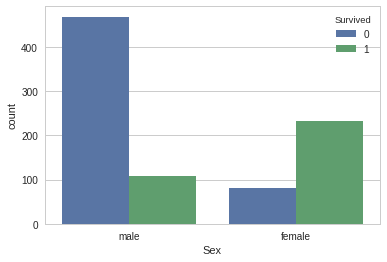

In [49]:
sns.set_style('whitegrid')
sns.countplot(x='Sex', hue='Survived',data=full_data)

This shows that females have a higher probability of surviving than males. Now I will predict that if a passenger is female, she survived, and if a passenger is male he did not survive.

In [31]:
def predictions_1(data):
    """ Model with one feature: 
            - Predict a passenger survived if they are female. """
    
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_1(full_data)

In [32]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 78.68%.


#### Examine survival based on derived Person feature

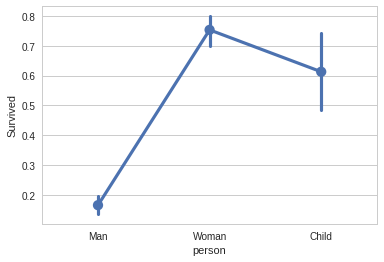

In [33]:
sns.set_style('whitegrid')
ax = sns.pointplot(x='person', y='Survived',data=full_data)
ax.set(ylabel='Survived',xlabel='person')
plt.show()

This shows that women are the most likely type of Person to survive, and have about a 75% chance of survival. Men are the least likely to survive with about 15% chance of surviving. Children (passengers with an age less than 10) are also likely to survive, with a survival chance of 60%. So now I will predict that if a passenger is female, she survives, and then if he is a Child, he survives, otherwise he does not survive.

In [34]:
def predictions_2(data):
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        elif passenger['Age'] < 10:
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_2(full_data)

In [35]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 79.35%.


#### Examine Pclass vs Survived

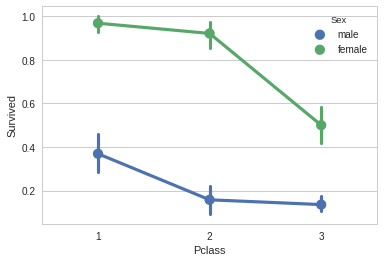

In [36]:
sns.set_style('whitegrid')
ax = sns.pointplot(x='Pclass', y='Survived',hue='Sex',data=full_data)
ax.set(ylabel='Survived',xlabel='Pclass')
plt.show()

This plot shows that passengers with a Pclass of 1 are more likely to survive, whereas passengers with a Plass of 3 are the least likely to survive. Again, females are more likely to survive for each Pclass. However, this won't improve the predictions for males since each Pclass still has less than 50% chance of surviving.

#### Examine survival based on Parch and Person

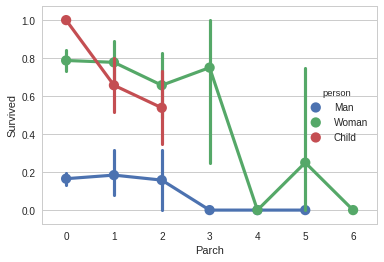

In [37]:
sns.set_style('whitegrid')
ax = sns.pointplot(x='Parch', y='Survived',hue='person',data=full_data)
ax.set(ylabel='Survived',xlabel='Parch')
plt.show()

This plot shows that women and children who have less than or equal to 3 family members with them are more likely to survive. I will include this in the predictions.

In [73]:
def predictions_3(data):
    
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['Parch'] <= 3 and passenger['Sex'] == 'female':
            predictions.append(1)
        elif passenger['Age'] < 10:
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_3(full_data)

In [74]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 79.91%.


### Examine Survival based on Pclass and Person

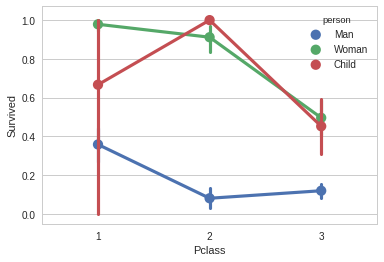

In [50]:
sns.set_style('whitegrid')
ax = sns.pointplot(x='Pclass', y='Survived',hue='person',data=full_data)
ax.set(ylabel='Survived',xlabel='Pclass')
plt.show()

This plot shows that women and children who have a Pclass less than 3 are more likely to survive. I will include this in the predictions.

In [75]:
def predictions_4(data):
    
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['person'] == 'Child' and passenger['Pclass'] < 3:
            predictions.append(1)
        elif passenger['Parch'] <= 3 and passenger['Sex'] == 'female':
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_4(full_data)

In [76]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 80.47%.


### Conclusion

I have achieved a prediction accuracy of 80.47% by predicting that children with a **Pclass** not equal to 3 survive and females with less than or equal to 3 **Parch**. Otherwise, the passenger does not survive. I have chosen these because I found from the exploratory analysis section that Children and Females have a greater probability of surviving than dying, while Males have a greater probability of dying than surviving. Furthermore, looking at survival based on more than one feature, I found that Children with a Pclass or 1 or 2 are more likely to survive than die, and Females with less than or equal to 3 Parch are more likely to survive than die.

### Limitations

One of the limitations of this analysis is that I have used only a sample of the data. Furthermore, I don't know if the sample was a random sample of the full data.

Another limitation is that **Embarked**, **Age**, and **Cabin** have missing values. I delt with the two missing **Embarked** values by using the most frequent embarked location. For the missing ages, I used the mean age of passengers grouped by **Sex** and **Pclass**, however this could affect the results of the **Age** analysis, as there are more men with missing values than females. If I had deleted the passengers with the missing ages, this would improve the **Age** analysis, since it would only include passengers whose true age was known. However, analyses of other variables would be limited as there would be less data.

A variable that would be useful in the analysis is whether or not a passenger was in a lifeboat, and if so, the lifeboat number. This would be useful because the lifeboats that left later were overfilled, and there were not enough lifeboats for all the passengers. So I think that this variable would have some predictive power. Reference: https://en.wikipedia.org/wiki/Lifeboats_of_the_RMS_Titanic